# 2. Feature Engineering for IT Support Tickets

This notebook creates features from processed ticket data and saves them for modeling.


In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import os
import joblib
import warnings
warnings.filterwarnings('ignore')

# Set input and output paths
INPUT_PATH = '../data'
OUTPUT_PATH = '../data/processed'

# Create output directory if it doesn't exist
if not os.path.exists(OUTPUT_PATH):
    os.makedirs(OUTPUT_PATH)

In [22]:
# Load processed data
INPUT_PATH = os.path.join('..', 'data', 'processed', 'processed_tickets.csv')
OUTPUT_PATH = os.path.join('..', 'data', 'processed', 'engineered_features.csv')
os.makedirs(os.path.dirname(OUTPUT_PATH), exist_ok=True)

df = pd.read_csv(INPUT_PATH)
# Convert timestamps if present
for col in ['creation_timestamp', 'closure_timestamp']:
    if col in df.columns:
        df[col] = pd.to_datetime(df[col], errors='coerce')

# Calculate resolution time if we have both timestamps
if 'creation_timestamp' in df.columns and 'closure_timestamp' in df.columns:
    df['resolution_time_hours'] = (df['closure_timestamp'] - df['creation_timestamp']).dt.total_seconds() / 3600
    # Filter out negative or zero resolution times
    df = df[df['resolution_time_hours'] > 0].copy()
    print('Data shape after filtering invalid resolution times:', df.shape)

print('Loaded processed data:', df.shape)
df.head() 

Loaded processed data: (135780, 23)


,subject,body,answer,type,queue,priority,language,version,tag_1,tag_2,...,tag_6,tag_7,tag_8,business_type,tag_9,priority_critical,priority_high,priority_low,priority_medium,priority_very_low
0,Wesentlicher Sicherheitsvorfall,"Sehr geehrtes Support-Team,\n\nich mÃ¶chte ein...",Vielen Dank fÃ¼r die Meldung des kritischen Si...,Incident,Technical Support,high,de,51.0,Security,Outage,...,Unknown,Unknown,Unknown,Unknown,0.0,-0.170325,-0.743028,-0.513819,-0.784493,-0.16423
1,Account Disruption,"Dear Customer Support Team,\n\nI am writing to...","Thank you for reaching out, <name>. We are awa...",Incident,Technical Support,high,en,51.0,Account,Disruption,...,Unknown,Unknown,Unknown,Unknown,0.0,-0.170325,-0.743028,-0.513819,-0.784493,-0.16423
2,Query About Smart Home System Integration Feat...,"Dear Customer Support Team,\n\nI hope this mes...",Thank you for your inquiry. Our products suppo...,Request,Returns and Exchanges,medium,en,51.0,Product,Feature,...,Unknown,Unknown,Unknown,Unknown,0.0,-0.170325,-0.743028,-0.513819,-0.784493,-0.16423
3,Inquiry Regarding Invoice Details,"Dear Customer Support Team,\n\nI hope this mes...",We appreciate you reaching out with your billi...,Request,Billing and Payments,low,en,51.0,Billing,Payment,...,Unknown,Unknown,Unknown,Unknown,0.0,-0.170325,-0.743028,-0.513819,-0.784493,-0.16423
4,Question About Marketing Agency Software Compa...,"Dear Support Team,\n\nI hope this message reac...",Thank you for your inquiry. Our product suppor...,Problem,Sales and Pre-Sales,medium,en,51.0,Product,Feature,...,Unknown,Unknown,Unknown,Unknown,0.0,-0.170325,-0.743028,-0.513819,-0.784493,-0.16423


In [23]:
# Create features based on available columns
if 'creation_timestamp' in df.columns and 'closure_timestamp' in df.columns:
    # Calculate resolution time
    if 'resolution_time_hours' not in df.columns:
        df['resolution_time_hours'] = (df['closure_timestamp'] - df['creation_timestamp']).dt.total_seconds() / 3600
        df = df[df['resolution_time_hours'] > 0].copy()
    
    # Time features
    df['hour_created'] = df['creation_timestamp'].dt.hour
    df['day_of_week'] = df['creation_timestamp'].dt.dayofweek
    df['is_weekend'] = df['day_of_week'].isin([5,6]).astype(int)
    df['month'] = df['creation_timestamp'].dt.month
    df['is_peak_hour'] = ((df['hour_created'] >= 9) & (df['hour_created'] <= 17)).astype(int)

# Text features from subject and body
for text_col in ['subject', 'body']:
    if text_col in df.columns:
        df[text_col] = df[text_col].astype(str)
        df[f'{text_col}_length'] = df[text_col].str.len()
        df[f'{text_col}_urgency_keywords'] = df[text_col].str.contains('urgent|critical|asap|immediate|down|crash', case=False, na=False).astype(int)
        
        # TF-IDF features
        vectorizer = TfidfVectorizer(max_features=100, stop_words='english')
        tfidf_matrix = vectorizer.fit_transform(df[text_col])
        tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=[f'{text_col}_tfidf_{i}' for i in range(tfidf_matrix.shape[1])])
        df = pd.concat([df.reset_index(drop=True), tfidf_df], axis=1)

# One-hot encode categoricals
categoricals = [c for c in ['priority', 'type', 'business_type'] if c in df.columns]
if categoricals:
    encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    encoded = encoder.fit_transform(df[categoricals])
    enc_df = pd.DataFrame(encoded, columns=encoder.get_feature_names_out(categoricals))
    df = pd.concat([df.drop(categoricals, axis=1), enc_df], axis=1)

# Scale numeric features except resolution_time_hours
numeric_cols = df.select_dtypes(include=np.number).columns.tolist()
if 'resolution_time_hours' in numeric_cols:
    numeric_cols.remove('resolution_time_hours')

if len(numeric_cols) > 0:
    scaler = StandardScaler()
    df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

print('Final feature shape:', df.shape)
df.head()

Final feature shape: (135780, 245)


,subject,body,answer,queue,language,version,tag_1,tag_2,tag_3,tag_4,...,business_type_Adobe Photoshop 2024,business_type_IT Consulting Firm,business_type_IT Consulting Service,business_type_IT Services,business_type_Online Store,business_type_Pit Services,business_type_Software Development Company,business_type_Tech Online Store,business_type_Unknown,business_type__IT_Services_
0,Wesentlicher Sicherheitsvorfall,"Sehr geehrtes Support-Team,\n\nich mÃ¶chte ein...",Vielen Dank fÃ¼r die Meldung des kritischen Si...,Technical Support,de,-0.054872,Security,Outage,Disruption,Data Breach,...,-0.005428,-0.07611,-0.010155,-0.161033,-0.050251,-0.008582,-0.067838,-0.144841,0.250215,-0.005428
1,Account Disruption,"Dear Customer Support Team,\n\nI am writing to...","Thank you for reaching out, <name>. We are awa...",Technical Support,en,-0.054872,Account,Disruption,Outage,IT,...,-0.005428,-0.07611,-0.010155,-0.161033,-0.050251,-0.008582,-0.067838,-0.144841,0.250215,-0.005428
2,Query About Smart Home System Integration Feat...,"Dear Customer Support Team,\n\nI hope this mes...",Thank you for your inquiry. Our products suppo...,Returns and Exchanges,en,-0.054872,Product,Feature,Tech Support,Unknown,...,-0.005428,-0.07611,-0.010155,-0.161033,-0.050251,-0.008582,-0.067838,-0.144841,0.250215,-0.005428
3,Inquiry Regarding Invoice Details,"Dear Customer Support Team,\n\nI hope this mes...",We appreciate you reaching out with your billi...,Billing and Payments,en,-0.054872,Billing,Payment,Account,Documentation,...,-0.005428,-0.07611,-0.010155,-0.161033,-0.050251,-0.008582,-0.067838,-0.144841,0.250215,-0.005428
4,Question About Marketing Agency Software Compa...,"Dear Support Team,\n\nI hope this message reac...",Thank you for your inquiry. Our product suppor...,Sales and Pre-Sales,en,-0.054872,Product,Feature,Feedback,Tech Support,...,-0.005428,-0.07611,-0.010155,-0.161033,-0.050251,-0.008582,-0.067838,-0.144841,0.250215,-0.005428


In [24]:
# Save engineered features
df.to_csv(OUTPUT_PATH, index=False)
print('Saved engineered features to:', OUTPUT_PATH)


Saved engineered features to: ..\data\processed\engineered_features.csv


# 2. Feature Engineering for IT Support Tickets

This notebook creates features from processed ticket data and saves them for modeling.


In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
import joblib
import os
import re
import nltk
from tqdm import tqdm

nltk.download('punkt', quiet=True)

get_ipython().run_line_magic('matplotlib', 'inline')

# Load the processed data
print("Loading processed data...")
df = pd.read_csv('../data/processed/processed_tickets.csv')

# Text processing
text_col = 'description_text'
print(f"\nProcessing text features from column: {text_col}")

# Initialize TF-IDF vectorizer
vectorizer = TfidfVectorizer(
    max_features=1000,  
    stop_words='english',
    ngram_range=(1, 2)
)

Loading processed data...

Processing text features from column: description_text

Processing text features from column: description_text


## 1. Load processed data


In [32]:
# Combine subject and body for text features
print("Preparing text data...")
df['text_content'] = df['subject'] + ' ' + df['body'].fillna('')

# Fit and transform the text data
print("\nFitting TF-IDF vectorizer...")
tfidf_matrix = vectorizer.fit_transform(df['text_content'])

# Save the vectorizer
os.makedirs('../data/processed', exist_ok=True)
joblib.dump(vectorizer, '../data/processed/tfidf_vectorizer.joblib')
print("\nSaved TF-IDF vectorizer")

# Save the TF-IDF features in sparse format
joblib.dump(tfidf_matrix, '../data/processed/tfidf_features.joblib')
print("Saved TF-IDF features in sparse format")

# Save feature names
feature_names = vectorizer.get_feature_names_out()
np.save('../data/processed/tfidf_feature_names.npy', feature_names)
print("Saved TF-IDF feature names")

print(f"\nText features shape: {tfidf_matrix.shape}")
print(f"Text features sparsity: {(1.0 - tfidf_matrix.nnz / (tfidf_matrix.shape[0] * tfidf_matrix.shape[1])) * 100:.2f}%")

Preparing text data...

Fitting TF-IDF vectorizer...

Fitting TF-IDF vectorizer...

Saved TF-IDF vectorizer
Saved TF-IDF features in sparse format
Saved TF-IDF feature names

Text features shape: (135780, 1000)
Text features sparsity: 96.07%

Saved TF-IDF vectorizer
Saved TF-IDF features in sparse format
Saved TF-IDF feature names

Text features shape: (135780, 1000)
Text features sparsity: 96.07%


## 2. Create features


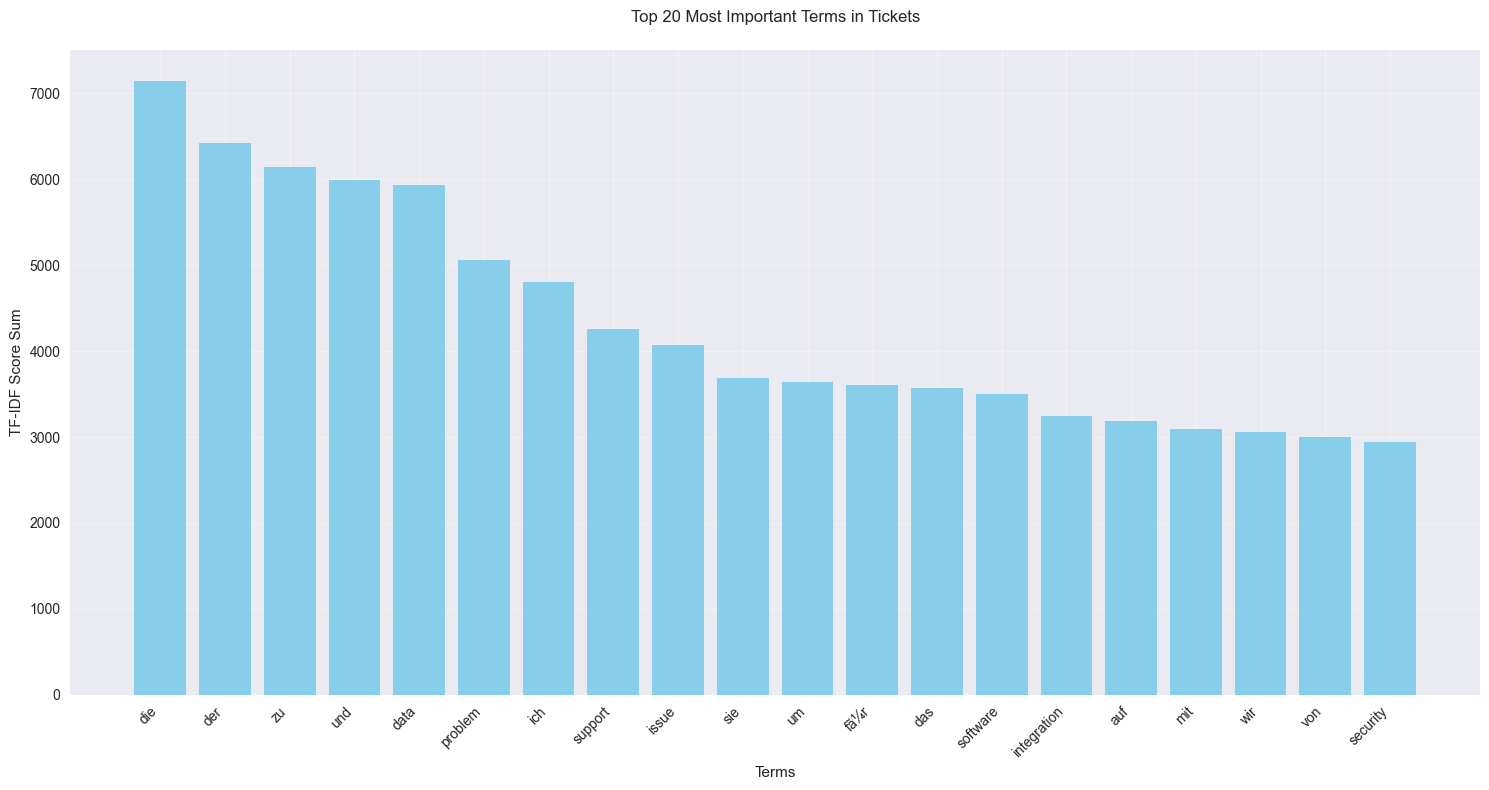


Summary of Feature Engineering:
Number of text features generated: 1000
Sparsity of text features: 96.07%

Top 10 most important terms:
die: 7148.9854
der: 6427.9256
zu: 6139.2652
und: 5995.1429
data: 5938.6740
problem: 5064.4680
ich: 4807.5847
support: 4256.8050
issue: 4075.0823
sie: 3689.9756


In [34]:
import matplotlib.pyplot as plt
from collections import Counter

# Calculate feature importance based on TF-IDF scores
feature_importance = np.asarray(tfidf_matrix.sum(axis=0)).ravel()
feature_names = vectorizer.get_feature_names_out()

# Get top features
top_n = 20
top_indices = feature_importance.argsort()[-top_n:][::-1]
top_features = feature_names[top_indices]
top_scores = feature_importance[top_indices]

# Create bar plot
plt.figure(figsize=(15, 8))
plt.bar(range(top_n), top_scores, color='skyblue')
plt.xticks(range(top_n), top_features, rotation=45, ha='right')
plt.title('Top 20 Most Important Terms in Tickets', pad=20)
plt.xlabel('Terms')
plt.ylabel('TF-IDF Score Sum')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Print summary statistics
print("\nSummary of Feature Engineering:")
print(f"Number of text features generated: {tfidf_matrix.shape[1]}")
print(f"Sparsity of text features: {(1.0 - tfidf_matrix.nnz / (tfidf_matrix.shape[0] * tfidf_matrix.shape[1])) * 100:.2f}%")
print(f"\nTop 10 most important terms:")
for term, score in zip(top_features[:10], top_scores[:10]):
    print(f"{term}: {score:.4f}")